# BME-230B Spring 2019 HW 2 Question 
Andrew Davidson aedavids@ucsc.edu

supposedly it took Andrew and Yianni 3 days to write the louvain clustering algo. The inner loop is about 100 lines.

Given we only get 10 pts for the implementation and we are running out of time lets use the scanpy version for now

## <span style="color:red">TODO implement 2.a Louvain Clustering</span>

- ref
    * [scanpy.tl.umap](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.tl.umap.html)
    * [scanpy.api.pp.neighbors](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.api.pp.neighbors.html?highlight=neighbors)
    * [scanpy.pl.umap](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.pl.umap.html#scanpy.pl.umap)
    * [scanpy.tl.louvain](https://icb-scanpy.readthedocs-hosted.com/en/stable/api/scanpy.tl.louvain.html#scanpy.tl.louvain)
    * [anndata](https://anndata.readthedocs.io/en/latest/anndata.AnnData.html)
        + "uns" stands for unstructured data
        + "obs" are panda data frame observations 
        + "obsm key-indexed multi-dimensional observations

In [1]:
from euclid_knn import knnG
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy.api as sc
import scanpy
print("scanpy.__version__:{}".format(scanpy.__version__))

scanpy.__version__:1.4.1


## 2.b. [5 pts] 
Turn in a UMAP plot of the combined dataset as you did in question #1, but
this time, color the cells by their Louvain cluster assignments determined for each cell
within each batch as a different color in each plot.

In [2]:
%%time
anndata = sc.read("PBMC.merged.h5ad")
knnG(anndata, n_neighbors=12)

emptying .uns...
CPU times: user 2min 28s, sys: 2.05 s, total: 2min 30s
Wall time: 2min 24s


In [3]:
%%time
# resolution : float, None
# For the default flavor ('vtraag'), you can provide a resolution 
# (higher resolution means finding more and smaller clusters), 
# which defaults to 1.0. See “Time as a resolution parameter” in [Lambiotte09].
scanpy.tl.louvain(anndata, resolution=1)

In [4]:
plt.figure(figsize=(10,10))
scanpy.tl.umap(anndata)

<Figure size 720x720 with 0 Axes>

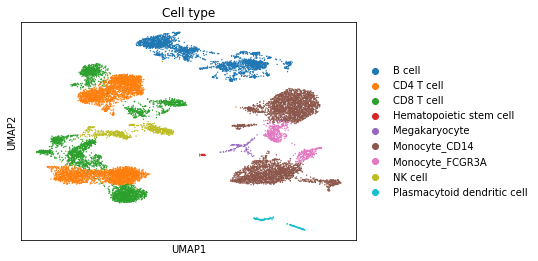

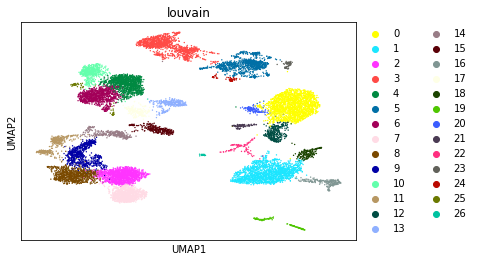

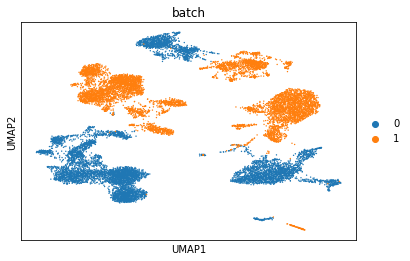

In [5]:
scanpy.pl.umap(anndata, color=['Cell type'])
scanpy.pl.umap(anndata, color=["louvain"])
scanpy.pl.umap(anndata, color=["batch"])

## 2.c. [5 pts] 
Turn in a table that lists each cluster and its best-matching cell type
annotation. The table should contain the cluster number and its best matching cell-type
annotation based on the hypergeometric analysis.

In [6]:
anndata.obs['louvain'].head(3)

index
data_3p-AAACCTGAGCATCATC-0    3
data_3p-AAACCTGAGCTAGTGG-0    8
data_3p-AAACCTGCACATTAGC-0    2
Name: louvain, dtype: category
Categories (27, object): [0, 1, 2, 3, ..., 23, 24, 25, 26]

In [7]:
anndata.obs.loc[:,['louvain', 'Cell type']].head()

,louvain,Cell type
index,,
data_3p-AAACCTGAGCATCATC-0,3,B cell
data_3p-AAACCTGAGCTAGTGG-0,8,CD4 T cell
data_3p-AAACCTGCACATTAGC-0,2,CD4 T cell
data_3p-AAACCTGCACTGTTAG-0,1,Monocyte_CD14
data_3p-AAACCTGCATAGTAAG-0,1,Monocyte_CD14


In [14]:
df = anndata.obs.loc[:,['louvain', 'Cell type']]
df.head()
grouped = df.groupby(['louvain', 'Cell type'])
# grouped.describe()
grouped['louvain'].count()

louvain  Cell type                  
0        B cell                            1
         Megakaryocyte                    16
         Monocyte_CD14                  1936
         Monocyte_FCGR3A                  15
1        Monocyte_CD14                  1703
         Monocyte_FCGR3A                  20
2        CD4 T cell                     1356
         CD8 T cell                        4
3        B cell                         1213
4        CD4 T cell                     1190
         CD8 T cell                       15
5        B cell                         1029
         Monocyte_CD14                     3
6        CD4 T cell                      967
         CD8 T cell                        1
7        CD4 T cell                        1
         CD8 T cell                      942
8        CD4 T cell                      889
         CD8 T cell                       12
9        CD4 T cell                       10
         CD8 T cell                      757
         Monocyte_

In [15]:
grouped = anndata.obs.loc[:,['louvain', 'Cell type']].groupby(['louvain', 'Cell type'])

In [11]:
#grouped.describe()

In [16]:
grouped['louvain'].count()

louvain  Cell type                  
0        B cell                            1
         Megakaryocyte                    16
         Monocyte_CD14                  1936
         Monocyte_FCGR3A                  15
1        Monocyte_CD14                  1703
         Monocyte_FCGR3A                  20
2        CD4 T cell                     1356
         CD8 T cell                        4
3        B cell                         1213
4        CD4 T cell                     1190
         CD8 T cell                       15
5        B cell                         1029
         Monocyte_CD14                     3
6        CD4 T cell                      967
         CD8 T cell                        1
7        CD4 T cell                        1
         CD8 T cell                      942
8        CD4 T cell                      889
         CD8 T cell                       12
9        CD4 T cell                       10
         CD8 T cell                      757
         Monocyte_

## reverse engineer scanpy umap
changes X_umap in adata.obsm. Shape is still the same